# **Assignment 3**
## **Group 3:**
* Karyl Grasparil
* Mariah Quinquito
* Yanna Polonia

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras import datasets
import pandas as pd
import numpy as np
import pathlib
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# **1. Data Steps**

## Loading CIFAR10 dataset into training and testing, features and labels numpy arrays using cifar10.load_data

In [2]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [3]:
print(f'x_train:\nType: {type(x_train)}\nShape: {x_train.shape}')
print(f'\ny_train:\nType: {type(y_train)}\nShape: {y_train.shape}')
print(f'\nx_test:\nType: {type(x_test)}\nShape: {x_test.shape}')
print(f'\ny_test:\nType: {type(y_test)}\nShape: {y_test.shape}')

x_train:
Type: <class 'numpy.ndarray'>
Shape: (50000, 32, 32, 3)

y_train:
Type: <class 'numpy.ndarray'>
Shape: (50000, 1)

x_test:
Type: <class 'numpy.ndarray'>
Shape: (10000, 32, 32, 3)

y_test:
Type: <class 'numpy.ndarray'>
Shape: (10000, 1)


## Printing Classes

In [4]:
# Obtaining uniques values per ecah class and their count, for training dataset
y_train_unique_labels, y_train_labels_count = np.unique(y_train, return_counts = True)

# Converting into a DataFrame for nicer later print
classes = pd.DataFrame(y_train_unique_labels, columns = ['Class'])
classes = classes.join(pd.DataFrame(y_train_labels_count, columns = ['Count']))
classes

,Class,Count
0,0,5000
1,1,5000
2,2,5000
3,3,5000
4,4,5000
5,5,5000
6,6,5000
7,7,5000
8,8,5000
9,9,5000


In [5]:
# Obtaining uniques values per ecah class and their count, for test dataset
y_test_unique_labels, y_test_labels_count = np.unique(y_test, return_counts = True)

# Converting into a DataFrame for nicer later print
test_classes = pd.DataFrame(y_test_unique_labels, columns = ['Class'])
test_classes = test_classes.join(pd.DataFrame(y_test_labels_count, columns = ['Count']))
test_classes

,Class,Count
0,0,1000
1,1,1000
2,2,1000
3,3,1000
4,4,1000
5,5,1000
6,6,1000
7,7,1000
8,8,1000
9,9,1000


## Creating a bar plot using seaborn.barplot of the number of elements in each category for the training dataset

In [6]:
# Storing the train and test dataset classess and counts in data
data = classes
data['Count'] = data['Count'] + test_classes['Count']

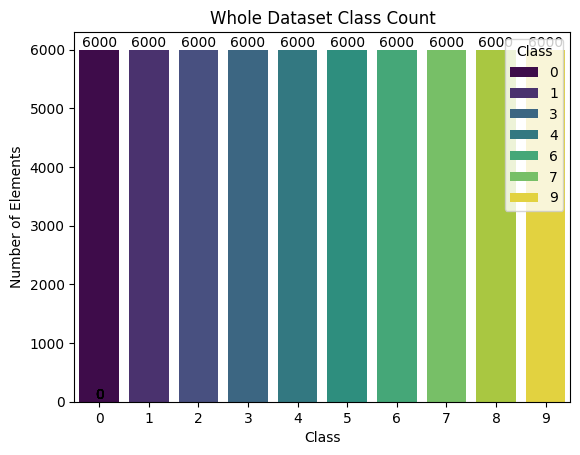

In [7]:
plot = sns.barplot(data = data, x = "Class", y = "Count", hue = "Class", palette = 'viridis')

# Adding counts on each bar
for p in plot.patches:
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_height()
    plot.text(x, y, f'{y:.0f}', ha='center', va='bottom')

plt.xlabel('Class')
plt.ylabel('Number of Elements')
plt.title('Whole Dataset Class Count')
plt.show()

### <span style='color:blue'>The barplot shows a balanced dataset, ecah class having the same count</span>

## Using sklearn.model_selection.train_test_split to split the test set into test and validation sets choosing appropriate proportions

In [8]:
x_test, x_val, y_test, y_val = \
    train_test_split(x_test, y_test, test_size = 0.5, random_state = 42)

In [9]:
# Printing shapes of test and validations sets members (x and y)
print(f'x_test shape: {x_test.shape}')
print(f'\ny_test shape: {y_test.shape}')
print(f'\ny_test shape: {x_val.shape}')
print(f'\ny_test shape: {y_val.shape}')

x_test shape: (5000, 32, 32, 3)

y_test shape: (5000, 1)

y_test shape: (5000, 32, 32, 3)

y_test shape: (5000, 1)


## <span>Creating train, test, and validation data generators using tensorflow.keras.preprocessing.image.ImageDataGenerator; each should scale the data by dividing by 255, and the training generator should also use data augmentation.</span>

In [10]:
path = pathlib.Path('').parent / 'generated_data'
train_dir = path / 'Training'
test_dir = path / 'Test'
val_dir = path / 'Validation'

In [11]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,  # Scaling the pixel values
    rotation_range=40,  # Randomly rotating images in the range (degrees)
    width_shift_range=0.2,  # Randomly shifting images horizontally
    height_shift_range=0.2,  # Randomly shifting images vertically
    shear_range=0.2,  # Shearing transformations
    zoom_range=0.2,  # Randomly zooming in
    horizontal_flip=True,  # Randomly flipping images
    fill_mode='nearest'  # Fill pixels that are newly created
)

In [12]:
train_image_generator = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.1, height_shift_range=0.1, \
                                           shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

In [13]:
batch_size = 32
img_height = 32
img_width = 32
channel = 3

In [14]:
# Fitting the generator to the training data
train_data_gen = train_image_generator.flow(x_train, y_train, batch_size = batch_size)

In [15]:
# Fitting the generator to the validation data
val_data_gen = train_image_generator.flow(x_val, y_val, batch_size = batch_size)

## **2. Modeling Steps**

## Using tf.keras.Sequential to create a convolutional neural network. Using at least two convolution layers and at least two pooling layers. Choosing an activation function for each layer, and making sure the input and output dimensions are appropriate for the data.

In [16]:
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, channel)), # 32 kernels, 3x3 small frame to learn for
    layers.MaxPooling2D((2, 2)), # This layer performs max pooling with a 2x2 window
    layers.Conv2D(64, (3, 3), activation='relu'), # Incrementing kernels amount for second 2D convolutional neural network
    layers.MaxPooling2D((2, 2)), # This layer performs max pooling with a 2x2 window
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'), # 64 neurons for the first hidden layer
    layers.Dense(10, activation='softmax') # 10 neurons considering we have 10 classes
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Compiling the model with a choice of optimizer, sparse_categorical_crossentropy for the loss function, and setting the metrics argument equal to ['accuracy'].

## Printing a summary of the model using tf.summary

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

## Training the model using the train and validation data generators; recording the training accuracy.

In [19]:
model.fit(train_data_gen, epochs=5, validation_data = val_data_gen)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 121s 75ms/step - accuracy: 0.2887 - loss: 1.9181 - val_accuracy: 0.4442 - val_loss: 1.5623
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 129s 83ms/step - accuracy: 0.4450 - loss: 1.5297 - val_accuracy: 0.5128 - val_loss: 1.3757
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 128s 74ms/step - accuracy: 0.4921 - loss: 1.4041 - val_accuracy: 0.5224 - val_loss: 1.3185
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 113s 72ms/step - accuracy: 0.5247 - loss: 1.3272 - val_accuracy: 0.5356 - val_loss: 1.3378
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 144s 73ms/step - accuracy: 0.5428 - loss: 1.2708 - val_accuracy: 0.5560 - val_loss: 1.2628


### <span style='color:blue'>Training accuracy = 0.5428 and validation accuracy = 0.5560, considering values the model is not overfitting. Although having a higher validation accuracy compared to the training accuracy, is generally a positive sign, based on accuracy values this model hasn't learned the training data too well at the expense of its performance on new data.</span>

## Experimenting with different architectures other hyperparameters to improve upon the results

In [20]:
# Generating model 1, reducing 2D convolutional layers to the minimum required and altering the values on each layer
model1 = Sequential([
    layers.Conv2D(64, (4, 4), activation='tanh', input_shape=(img_height, img_width, channel)),
    layers.MaxPooling2D((3, 3)),
    layers.Conv2D(128, (3, 3), activation='tanh'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='tanh'),
    layers.Dense(10, activation='softmax')
])

In [21]:
# Compiling model1 keeping values for the original model
model1.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
# Printing model1 summary
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 29, 29, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │          36,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 114,218 (446.16 KB)

 Trainable params: 114,218 (446.16 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Training the model using the train and validation data generators; recording the training accuracy
model1.fit(train_data_gen, epochs=5, validation_data = val_data_gen)

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 137s 87ms/step - accuracy: 0.3352 - loss: 1.8408 - val_accuracy: 0.4512 - val_loss: 1.5498
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 146s 89ms/step - accuracy: 0.4478 - loss: 1.5455 - val_accuracy: 0.4854 - val_loss: 1.4526
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 133s 85ms/step - accuracy: 0.4826 - loss: 1.4664 - val_accuracy: 0.5096 - val_loss: 1.4170
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 130s 83ms/step - accuracy: 0.4988 - loss: 1.4272 - val_accuracy: 0.5086 - val_loss: 1.3926
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 130s 83ms/step - accuracy: 0.5142 - loss: 1.3864 - val_accuracy: 0.5124 - val_loss: 1.3733


### <span style='color:blue'>Training accuracy = 0.5142 and validation accuracy = 0.5124. Based on previous results the model apparently is not effectively learning to distinguish between classes (accuracy around 50%), and it is a bit overfitting.</span>

In [24]:
# Generating model 2, setting 3 2D convolutional layers and altering the values on each layer
model2 = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, channel)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [25]:
# Compiling model2 keeping values for the original model
model2.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
# Printing model2 summary
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,730 (495.04 KB)

 Trainable params: 126,730 (495.04 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Training the model using the train and validation data generators; recording the training accuracy
model2.fit(train_data_gen, epochs=5, validation_data = val_data_gen)

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 121s 76ms/step - accuracy: 0.3017 - loss: 1.8825 - val_accuracy: 0.4516 - val_loss: 1.5143
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 140s 75ms/step - accuracy: 0.4671 - loss: 1.4822 - val_accuracy: 0.5118 - val_loss: 1.3710
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 75ms/step - accuracy: 0.5143 - loss: 1.3645 - val_accuracy: 0.5364 - val_loss: 1.3106
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 136s 87ms/step - accuracy: 0.5403 - loss: 1.2928 - val_accuracy: 0.5742 - val_loss: 1.2127
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 122s 78ms/step - accuracy: 0.5719 - loss: 1.2156 - val_accuracy: 0.5624 - val_loss: 1.2691


### <span style='color:blue'>Training accuracy = 0.5719 and validation accuracy = 0.5624. Based on accuracy values this model hasn't learned the training data too well at the expense of its performance on new data, being the model overfitting.</span>

## Starting a new model by loading one of the models from tensorflow.keras.applications along with the pretrained weights; don't include the top layer. Describing the model you chose using markdown and explain why you think it will work well for this use case.

In [28]:
# Loading MobileNetV2 model with pre-trained weights and exclude the top layer
base_model = MobileNetV2(weights='imagenet', include_top = False, input_shape = (img_height, img_width, channel))

<ipython-input-28-4867ad7a2406>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top = False, input_shape = (img_height, img_width, channel))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Checking if MobileNetV2 model comes with preprocess_input function, if so using it properly with the data before training.

In [29]:
# Preprocessing the data using preprocess_input
x_train_preprocessed = preprocess_input(x_train)  # Applying preprocessing to training data
x_val_preprocessed = preprocess_input(x_val)    # Applying preprocessing to validation data
x_test_preprocessed = preprocess_input(x_test)  # Applying preprocessing to test data

In [30]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 16, 16, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 16, 16, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 16, 16, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 16, 16, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 16, 16, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 16, 16, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 16, 16, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 16, 16, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 16, 16, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 17, 17, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 8, 8, 96)       │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

### <span style='color:blue'>According to <a href='https://www.mathworks.com/help/deeplearning/ref/mobilenetv2.html'>'MathWorks'</a> MobileNet-v2 is a convolutional neural network that is 53 layers deep. This model has a pretrained version of the network on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. Based on previous statement and that the selected model has a lightweight architecture, we decided to try it in this case.</span>

In [31]:
base_model.output

<KerasTensor shape=(None, 1, 1, 1280), dtype=float32, sparse=False, name=keras_tensor_180>

## Adding on a new top layer with the appropiate hyperparameters choice. Choosing a number of layers to freeze.

In [32]:
# Freezing all but the last 4 layers of the base_model
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Preparing everything to add layers to base_model
base_model_output = base_model.output

# Adding Global average pooling layer to reduce the dimensionality of the output and matching the expected
# input shape for the dense layers
base_model_output = layers.GlobalAveragePooling2D()(base_model_output)

# Adding a fully connected layer
base_model_output = layers.Dense(128, activation='relu')(base_model_output)

# Output layer for multiclass classification (10 classes)
base_model_output = layers.Dense(10, activation='softmax')(base_model_output)

In [33]:
# Creating the final model
final_base_model = Model(inputs = base_model.input, outputs = base_model_output)

## Compiling the model with a choice of an optimizer (adam) and a loss function (sparse_categorical_crossetropy), and metrics=['accuracy']

In [34]:
# Compiling final_base_model
final_base_model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Printing the summary of the model

In [35]:
final_base_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 16, 16, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 16, 16, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 16, 16, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 16, 16, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 16, 16, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 16, 16, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 16, 16, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 16, 16, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 16, 16, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 17, 17, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 8, 8, 96)       │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 578,058 (2.21 MB)

 Non-trainable params: 1,845,184 (7.04 MB)

## Training the model using the train and validation data generators; recording the training accuracy.

In [36]:
# Training the model using the train and validation data generators; recording the training accuracy
final_base_model.fit(x_train_preprocessed, y_train, epochs=5, validation_data=(x_val_preprocessed, y_val))

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 117s 68ms/step - accuracy: 0.4707 - loss: 1.5416 - val_accuracy: 0.5498 - val_loss: 1.3124
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 138s 66ms/step - accuracy: 0.5741 - loss: 1.2074 - val_accuracy: 0.5854 - val_loss: 1.1916
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 66ms/step - accuracy: 0.5909 - loss: 1.1549 - val_accuracy: 0.5898 - val_loss: 1.1808
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 135s 62ms/step - accuracy: 0.6087 - loss: 1.0933 - val_accuracy: 0.5846 - val_loss: 1.2229
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 62ms/step - accuracy: 0.6266 - loss: 1.0428 - val_accuracy: 0.6002 - val_loss: 1.1710


### <span style='color:blue'>Training accuracy = 0.6266 and validation accuracy = 0.6002. Based on these values we can conclude that the model is overfitting, showing a good performance on the training set, but the drop in validation accuracy suggests it may not be generalizing well when dealing with new data.</span>

## Experimenting with different architectures, different numbers of frozen layers, and other hyperparameters to improve upon the results

In [37]:
# Freezing all layers of base_model, keeping just the last 2
for layer in base_model.layers[:-2]:
    layer.trainable = False

# Preparing everything to add layers to base_model
base_model_output2 = base_model.output

# Adding Global average pooling layer to reduce the dimensionality of the output and matching the expected
# input shape for the dense layers
base_model_output2 = layers.GlobalAveragePooling2D()(base_model_output2)

# Adding a fully connected layer, changing to 'softmax'
base_model_output2 = layers.Dense(32, activation='softmax')(base_model_output2)

# Output layer for multiclass classification (10 classes)
base_model_output2 = layers.Dense(10, activation='softmax')(base_model_output2)

In [38]:
# Creating the customized_base_model1
customized_base_model1 = Model(inputs = base_model.input, outputs = base_model_output2)

In [39]:
# Compiling customized_base_model1
customized_base_model1.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
# Printing customized_base_model1
customized_base_model1.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 16, 16, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 16, 16, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 16, 16, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 16, 16, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 16, 16, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 16, 16, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 16, 16, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 16, 16, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 16, 16, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 17, 17, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 8, 8, 96)       │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,299,306 (8.77 MB)

 Trainable params: 43,882 (171.41 KB)

 Non-trainable params: 2,255,424 (8.60 MB)

In [41]:
# Training the model using the train and validation data generators; recording the training accuracy
customized_base_model1.fit(x_train_preprocessed, y_train, epochs=5, validation_data=(x_val_preprocessed, y_val))

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 72s 42ms/step - accuracy: 0.4156 - loss: 1.9516 - val_accuracy: 0.4886 - val_loss: 1.5460
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 77s 39ms/step - accuracy: 0.5127 - loss: 1.4496 - val_accuracy: 0.5086 - val_loss: 1.4263
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 86s 41ms/step - accuracy: 0.5353 - loss: 1.3430 - val_accuracy: 0.5086 - val_loss: 1.3958
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 87s 45ms/step - accuracy: 0.5447 - loss: 1.2795 - val_accuracy: 0.5118 - val_loss: 1.3786
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 45ms/step - accuracy: 0.5520 - loss: 1.2436 - val_accuracy: 0.5212 - val_loss: 1.3670


### <span style='color:blue'>Training accuracy = 0.5520 and validation accuracy = 0.5212. Based on previous results, we can conclude that the model is overfitting; besides, being the accuracy values not that high, this means the model is not handling complex patterns in data appropiately.</span>

In [42]:
# Freezing all layers of base_model
for layer in base_model.layers:
    layer.trainable = False

# Preparing everything to add layers to base_model
base_model_output1 = base_model.output

# Adding Global average pooling layer to reduce the dimensionality of the output and matching the expected
# input shape for the dense layers
base_model_output1 = layers.GlobalAveragePooling2D()(base_model_output1)

# Adding a fully connected layer, changing to 'tanh'
base_model_output1 = layers.Dense(128, activation='tanh')(base_model_output1)

# Output layer for multiclass classification (10 classes)
base_model_output1 = layers.Dense(10, activation='softmax')(base_model_output1)

In [43]:
# Creating the customized_base_model
customized_base_model = Model(inputs = base_model.input, outputs = base_model_output1)

In [44]:
# Compiling customized_base_model
customized_base_model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [45]:
# Printing customized_base_model
customized_base_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 16, 16, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 16, 16, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 16, 16, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 16, 16, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 16, 16, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 16, 16, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 16, 16, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 16, 16, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 16, 16, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 17, 17, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 8, 8, 96)       │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [46]:
# Training the model using the train and validation data generators; recording the training accuracy
customized_base_model.fit(x_train_preprocessed, y_train, epochs=5, validation_data=(x_val_preprocessed, y_val))

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 69s 40ms/step - accuracy: 0.6086 - loss: 1.1201 - val_accuracy: 0.6202 - val_loss: 1.1085
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 67s 43ms/step - accuracy: 0.6881 - loss: 0.8754 - val_accuracy: 0.6098 - val_loss: 1.1378
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 86s 45ms/step - accuracy: 0.7052 - loss: 0.8229 - val_accuracy: 0.6130 - val_loss: 1.1474
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - accuracy: 0.7300 - loss: 0.7587 - val_accuracy: 0.6134 - val_loss: 1.1544
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 74s 40ms/step - accuracy: 0.7440 - loss: 0.7124 - val_accuracy: 0.6150 - val_loss: 1.1625


### <span style='color:blue'>Training accuracy = 0.7440 and validation accuracy = 0.6150. Based on previous values we can conclude the model is overfitting, while the model shows good performance on the training set, the lower validation accuracy indicates it may struggle to generalize while dealing with new data.</span>

In [85]:
# Freezing all layers of base_model
for layer in base_model.layers:
    layer.trainable = False

# Preparing everything to add layers to base_model
base_model_output6 = base_model.output

# Adding Global average pooling layer to reduce the dimensionality of the output and matching the expected
# input shape for the dense layers
base_model_output6 = layers.GlobalAveragePooling2D()(base_model_output6)

# Adding a fully connected layer, changing to 'tanh'
base_model_output6 = layers.Dense(128, activation='tanh')(base_model_output6)

# Adding an extra fully connected layer, using 'tanh' as activation function
base_model_output6 = layers.Dense(256, activation='tanh')(base_model_output6)

# Adding a dropout of 60% to reduce the overfitting effect in previous model
base_model_output6 = layers.Dropout(.6)(base_model_output6)

# Output layer for multiclass classification (10 classes)
base_model_output6 = layers.Dense(10, activation='softmax')(base_model_output6)

In [86]:
# Creating the customized_base_model4
customized_base_model4 = Model(inputs = base_model.input, outputs = base_model_output6)

In [87]:
# Compiling customized_base_model4
customized_base_model4.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [88]:
# Printing customized_base_model4
customized_base_model4.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 16, 16, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 16, 16, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 16, 16, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 16, 16, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 16, 16, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 16, 16, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 16, 16, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 16, 16, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 16, 16, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 17, 17, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 8, 8, 96)       │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,457,546 (9.37 MB)

 Trainable params: 199,562 (779.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [89]:
# Training the model using the train and validation data generators; recording the training accuracy
customized_base_model4.fit(x_train_preprocessed, y_train, epochs=5, validation_data=(x_val_preprocessed, y_val))

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 76s 44ms/step - accuracy: 0.5515 - loss: 1.2980 - val_accuracy: 0.6116 - val_loss: 1.1401
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.6600 - loss: 0.9716 - val_accuracy: 0.6164 - val_loss: 1.1292
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 69s 44ms/step - accuracy: 0.6824 - loss: 0.9094 - val_accuracy: 0.6110 - val_loss: 1.1551
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 68s 43ms/step - accuracy: 0.6920 - loss: 0.8854 - val_accuracy: 0.6274 - val_loss: 1.1234
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 78s 41ms/step - accuracy: 0.7000 - loss: 0.8567 - val_accuracy: 0.6154 - val_loss: 1.1596


### <span style='color:blue'>Training accuracy = 0.7000 and validation accuracy = 0.6154. Based on previous values we can conclude the model is overfitting, while the model shows a decent performance on the training set, it decreased on the validation set, being this a warning sign related to how well the model generalize while dealing with new data.</span>

# 3. Conclusion

## Generating the validation confusion matriz for both the custom CNN and transfer learning models

In [52]:
x_val_scaled = x_val.astype('float32') / 255.0

In [53]:
# Generating predictions based on validation set, using np.argmax to actually get integers values for each predicted class (model)
val_predictions_model = np.argmax(model.predict(x_val_scaled), axis = 1)
val_predictions_model

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


array([2, 1, 4, ..., 0, 6, 1])

In [54]:
# Generating the confusion matrix for validation set (model)
val_cnf_matrix_model = confusion_matrix(y_val, val_predictions_model)
val_cnf_matrix_model

array([[337,  38,  23,   0,   5,   2,   2,  10,  31,  31],
       [  5, 422,   1,   0,   0,   0,   7,   2,   3,  46],
       [ 46,  19, 231,   4,  75,  31,  60,  25,  14,  20],
       [ 13,  30,  56,  88,  46,  71, 127,  34,  11,  24],
       [ 15,  16,  35,   4, 277,  10,  75,  55,   7,  12],
       [ 12,  12,  51,  32,  42, 220,  46,  37,   7,  19],
       [  1,  16,  13,   6,  21,  10, 417,   8,   4,  15],
       [ 10,   9,  16,   5,  33,  28,  13, 375,   1,  38],
       [ 80,  43,   7,   3,   3,   4,   6,   4, 319,  20],
       [ 23, 125,   4,   1,   3,   2,   7,   0,  11, 322]])

In [55]:
# Generating predictions based on validation set, using np.argmax to actually get integers values for each predicted class (model1)
val_predictions_model1 = np.argmax(model1.predict(x_val_scaled), axis = 1)
val_predictions_model1

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


array([2, 1, 6, ..., 0, 6, 1])

In [56]:
# Generating the confusion matrix for validation set (model1)
val_cnf_matrix_model1 = confusion_matrix(y_val, val_predictions_model1)
val_cnf_matrix_model1

array([[198,  61,  12,  14,   6,   3,  11,  15,  92,  67],
       [  1, 396,   0,   2,   1,   3,  17,   3,   4,  59],
       [ 38,  27, 151,  45,  62,  59,  81,  32,  11,  19],
       [  7,  20,  14, 203,  18,  72,  98,  24,  10,  34],
       [ 11,  15,  17,  54, 210,  17,  92,  62,   7,  21],
       [  5,  13,  17, 105,  14, 208,  44,  34,   8,  30],
       [  2,   7,   8,  29,   8,   8, 420,   6,   4,  19],
       [  1,  15,   6,  25,  23,  43,  20, 329,   3,  63],
       [ 22,  53,   5,   9,   3,   4,  18,   5, 318,  52],
       [  4, 106,   3,   3,   1,   2,  20,   5,  14, 340]])

In [57]:
# Generating predictions based on validation set, using np.argmax to actually get integers values for each predicted class (model2)
val_predictions_model2 = np.argmax(model2.predict(x_val_scaled), axis = 1)
val_predictions_model2

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


array([0, 1, 6, ..., 0, 6, 1])

In [58]:
# Generating the confusion matrix for validation set (model2)
val_cnf_matrix_model2 = confusion_matrix(y_val, val_predictions_model2)
val_cnf_matrix_model2

array([[308,  75,   3,   5,   8,   1,   3,   2,  36,  38],
       [  4, 458,   0,   1,   0,   0,   6,   0,   1,  16],
       [ 84,  43, 135,  23,  63,  35,  80,  17,  18,  27],
       [ 23,  54,  12, 113,  39,  69, 121,  10,  25,  34],
       [ 30,  27,   9,  12, 271,  10,  95,  34,   7,  11],
       [ 12,  29,  10,  49,  21, 234,  66,  13,  13,  31],
       [  1,  17,   4,  10,  13,   6, 436,   2,   6,  16],
       [ 17,  37,   1,   9,  34,  35,  27, 321,   2,  45],
       [ 49,  82,   0,   1,   2,   0,   6,   1, 325,  23],
       [  7, 127,   0,   0,   2,   1,   6,   1,  10, 344]])

In [59]:
# Generating predictions based on validation set, using np.argmax to actually get integers values for each predicted class (final_base_model)
val_predictions_final_base_model = np.argmax(final_base_model.predict(x_val_scaled), axis = 1)
val_predictions_final_base_model

157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step


array([4, 6, 3, ..., 2, 3, 3])

In [60]:
# Generating the confusion matrix for validation set (final_base_model)
val_cnf_matrix_final_base_model = confusion_matrix(y_val, val_predictions_final_base_model)
val_cnf_matrix_final_base_model

array([[348,   1,  18,   8,  18,   0,   0,   2,  84,   0],
       [ 40,  65,   5,  44,  13,   4,  44,   5, 244,  22],
       [ 88,   1, 204,  65,  81,   7,  36,   6,  36,   1],
       [ 52,   2,  33, 263,  57,   8,  43,   0,  42,   0],
       [ 40,   1,  37,  47, 333,   3,  13,   8,  24,   0],
       [ 33,   1,  30, 212,  62,  95,  26,   7,  12,   0],
       [ 32,   1,  49,  85,  80,   2, 247,   0,  15,   0],
       [ 59,   0,  28,  75, 158,  13,  10, 123,  59,   3],
       [ 86,   2,   6,  13,  16,   0,  12,   0, 352,   2],
       [ 47,   7,   5,  41,  33,   0,  14,   1, 239, 111]])

In [61]:
# Generating predictions based on validation set, using np.argmax to actually get integers values for each predicted class (customized_base_model)
val_predictions_customized_base_model = np.argmax(customized_base_model.predict(x_val_scaled), axis = 1)
val_predictions_customized_base_model

157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step


array([4, 8, 6, ..., 0, 8, 3])

In [62]:
# Generating the confusion matrix for validation set (customized_base_model)
val_cnf_matrix_customized_base_model = confusion_matrix(y_val, val_predictions_customized_base_model)
val_cnf_matrix_customized_base_model

array([[362,   2,  22,   9,  24,   3,   0,   5,  50,   2],
       [ 78, 132,  12,  20,  13,  11,  23,  11, 160,  26],
       [ 86,   3, 246,  46,  66,  22,  24,   8,  23,   1],
       [ 50,   3,  55, 207,  55,  53,  31,   3,  43,   0],
       [ 43,   1,  60,  25, 318,  11,  15,  18,  15,   0],
       [ 27,   1,  33, 127,  51, 173,  38,  18,  10,   0],
       [ 37,   1,  87,  50,  69,  11, 241,   0,  15,   0],
       [ 45,   1,  48,  38, 133,  43,   6, 176,  35,   3],
       [132,   4,  16,  13,  16,   2,   5,   1, 297,   3],
       [ 77,  29,   5,  36,  33,  10,   7,  10, 146, 145]])

In [63]:
# Generating predictions based on validation set, using np.argmax to actually get integers values for each predicted class (customized_base_model1)
val_predictions_customized_base_model1 = np.argmax(customized_base_model1.predict(x_val_scaled), axis = 1)
val_predictions_customized_base_model1

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step


array([6, 8, 6, ..., 0, 3, 6])

In [64]:
# Generating the confusion matrix for validation set (customized_base_model)
val_cnf_matrix_customized_base_model1 = confusion_matrix(y_val, val_predictions_customized_base_model1)
val_cnf_matrix_customized_base_model1

array([[292,   1,  41,  10,  10,   1,   7,  30,  86,   1],
       [ 38,  83,   7,  36,   7,   4,  57,  22, 194,  38],
       [ 50,   1, 236,  44,  19,  26,  60,  58,  30,   1],
       [ 21,   1,  46, 207,  12,  46, 100,  33,  34,   0],
       [ 19,   1,  45,  28,  64,   7,  57, 263,  22,   0],
       [ 13,   0,  32, 152,  10, 153,  64,  42,  11,   1],
       [ 12,   0,  48,  27,  20,  11, 365,  17,  11,   0],
       [ 24,   0,  33,  52,  21,  24,  17, 311,  46,   0],
       [ 51,   2,  17,  13,   6,   0,  13,  20, 364,   3],
       [ 27, 101,   7,  37,  14,   9,  29,  41, 196,  37]])

In [90]:
# Generating predictions based on validation set, using np.argmax to actually get integers values for each predicted class (customized_base_model5)
val_predictions_customized_base_model4 = np.argmax(customized_base_model4.predict(x_val_scaled), axis = 1)
val_predictions_customized_base_model4

157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step


array([6, 8, 3, ..., 0, 8, 3])

In [91]:
# Generating the confusion matrix for validation set (customized_base_model4)
val_cnf_matrix_customized_base_model4 = confusion_matrix(y_val, val_predictions_customized_base_model4)
val_cnf_matrix_customized_base_model4

array([[356,   0,  17,   3,  26,   1,   4,   3,  69,   0],
       [ 73,  88,   9,  25,  12,  11,  23,   6, 218,  21],
       [ 93,   2, 253,  27,  62,  28,  29,   2,  29,   0],
       [ 66,   3,  59, 153,  41,  87,  45,   1,  44,   1],
       [ 38,   1,  64,  19, 292,  21,  38,   9,  24,   0],
       [ 32,   2,  45,  75,  46, 224,  35,   8,  11,   0],
       [ 35,   1,  67,  29,  44,  17, 306,   0,  12,   0],
       [ 64,   0,  56,  31, 149,  48,   8, 119,  50,   3],
       [ 99,   1,  12,   8,  13,   3,   3,   0, 348,   2],
       [ 57,   8,   8,  23,  28,  16,   6,   5, 246, 101]])

## Comparing the training and validation accuracies, as well as validation confusion matriz for both: the custom CNN and transfer learning models

<table>
<tr><tr><th><th style="text-align:center">Model Name<th style="text-align:center">Training Accuracy<th style="text-align:center">Validation Accuracy<tr><tr>
<tr><td><td style="text-align:center">model<td style="text-align:left">0.5428<td style="text-align:left">0.5560<td>
<tr><td><td style="text-align:center">model1<td style="text-align:left">0.5142<td style="text-align:left">0.5124<td>
<tr><td><td style="text-align:center">model2<td style="text-align:left">0.5624<td style="text-align:left">0.5702<td>
<tr><td><td style="text-align:center">final_base_model<td style="text-align:left">0.6266<td style="text-align:left">0.6002<td>
<tr><td><td style="text-align:center">customized_base_model<td style="text-align:left">0.7440<td style="text-align:left">0.6150<td>
<tr><td><td style="text-align:center">customized_base_model1<td style="text-align:left">0.5520<td style="text-align:left">0.5212<td>
<tr><td><td style="text-align:center">customized_base_model4<td style="text-align:left">0.7000<td style="text-align:left">0.6154<td>
</table>

### <span style='color:blue'>Based on results obatined the best choice would be customized_base_model4 (Training Accuracy: 70%, Validation Accuracy: 61.54%), because is the most balanced choice for the CIFAR-10 dataset. While it has lower training accuracy than customized_base_model, its validation accuracy is better, indicating that it generalizes better to new data. The smaller gap between training and validation accuracies suggests that it is less likely to be overfitting (customized_base_model4).</span>

## Finding the testing accuracy and confusion matriz of only the best model

In [105]:
best_model = customized_base_model4

In [106]:
# Generating predictions based on test set, using np.argmax to actually get integers values for each predicted class (best_model)
test_predictions_best_model = np.argmax(best_model.predict(x_test_preprocessed), axis = 1)
test_predictions_best_model

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step


array([0, 5, 4, ..., 1, 4, 9])

In [107]:
# Generating the confusion matrix for validation set (customized_base_model)
test_cnf_matrix_best_model = confusion_matrix(y_test, test_predictions_best_model)
test_cnf_matrix_best_model

array([[374,  11,  26,   9,   7,   6,   7,   9,  59,  13],
       [ 20, 340,   6,  11,   3,   7,   6,   8,  39,  74],
       [ 51,   4, 262,  20,  42,  33,  37,  13,   9,   4],
       [ 17,  16,  49, 153,  23, 140,  44,  31,  12,  15],
       [ 23,   2,  45,  11, 277,  31,  48,  38,  15,   4],
       [ 12,   7,  38,  52,  29, 339,  20,  15,   3,   7],
       [ 11,   6,  34,  18,  20,  40, 350,   4,   4,   2],
       [ 15,   7,  20,  12,  62,  49,   9, 283,   7,   8],
       [ 53,  30,  12,   8,  11,   4,   1,   7, 360,  25],
       [ 22,  81,   5,   9,   5,   7,   2,  12,  35, 324]])

## Using the model to make predictions on at least three other images from one of the 10 classes

In [108]:
# Defining the class labels for ciphar-10
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [109]:
# Choosing three images from the same class (class 4: 'deer' would be the choice in this case)
# Picking indices of the images that correspond to class 4 and storing it in a numpy array named indices
indices = np.where(y_test == 4)[0]
indices

array([   3,    8,   34,   39,   59,   63,   75,   83,   99,  107,  111,
        128,  172,  189,  194,  210,  212,  219,  236,  254,  288,  289,
        296,  299,  308,  324,  325,  326,  330,  331,  345,  380,  383,
        400,  403,  415,  423,  430,  442,  452,  467,  472,  499,  520,
        526,  531,  551,  559,  563,  569,  579,  580,  592,  627,  637,
        642,  644,  650,  654,  655,  670,  671,  697,  708,  721,  727,
        730,  740,  755,  763,  766,  770,  775,  777,  793,  799,  800,
        802,  829,  838,  845,  846,  855,  856,  865,  868,  878,  879,
        894,  898,  943,  957,  959,  966,  979,  995,  998,  999, 1006,
       1016, 1018, 1027, 1038, 1041, 1043, 1053, 1055, 1064, 1066, 1069,
       1070, 1079, 1083, 1105, 1115, 1116, 1127, 1130, 1150, 1163, 1172,
       1173, 1181, 1192, 1194, 1198, 1200, 1201, 1202, 1213, 1222, 1223,
       1228, 1229, 1232, 1237, 1238, 1240, 1251, 1283, 1284, 1301, 1310,
       1316, 1335, 1342, 1375, 1390, 1395, 1400, 14

In [110]:
# Getting the sample images (three) and their true labels
sample_indices = np.random.choice(indices, size=3, replace=False) # Ramdomly selecting three indices
sample_images = x_test_preprocessed[sample_indices] # Storing sample images from preprocessed test data
sample_labels = y_test[sample_indices] # Storing true labels for the sample images previously stored

# Making predictions based on sample images
predictions = best_model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([2, 4, 4])

## Visualizing the predictions

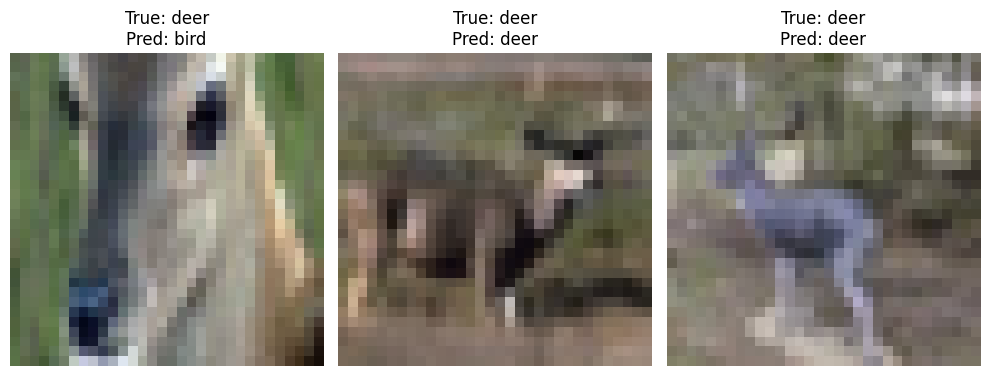

In [114]:
sample_images_unprocessed = x_test[sample_indices] # Storing sample images from test data to avoid dark pictures

# Plotting the results
plt.figure(figsize=(10, 4))

for i, idx in enumerate(sample_indices):
    plt.subplot(1, 3, i + 1)
    plt.imshow(sample_images_unprocessed[i])
    plt.title(f"True: {class_labels[sample_labels[i][0]]}\nPred: {class_labels[predicted_classes[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Commenting on how well the model works to make predictions for this use case

### <span style='color:blue'>Based on the results, we can conclude that the model behaves 'decently,' but other adjustments are needed to increase its accuracy. Due to time constraints, we could not explore other hyperparameter and layer setup combination.</span>